# Case 1. Heart Disease Classification

#### Joonas Lehikoinen, Przemyslaw Zuchmanski
##### 31.01.2020
### Helsinki Metropolia University of Applied Sciences

The main object is to created and train a dense neural network to predict the presence of heart disease on the base of heart disease cleveland data downloaded from the site: https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/ .

##### Data
The data contains values of various health factors usefull in detecting heart diseases. There are 13 factors described in 13 coluns. 14th column describes if the patint sufers from heart disease. The number of records is 303. Missing values (detected in 6 raws) were replaced with 0. 

In [1]:
%pylab inline
import pandas as pd
import numpy
from sklearn import preprocessing
import tensorflow as tf
from sklearn.model_selection import train_test_split


#names of columns
names = ["age","sex","cp","trestbps","chol","fbs","restecg",
                            "thalach","examg","oldpeak","slope","ca","thal","num"]
                   
#reading data and giving names for columns, detecting NaN valuess
df = pd.read_csv("processed.cleveland.data", 
                 names=names,
                     header=None, 
                     index_col = None, 
                     na_values = '?')

#replacing NaN values with 0
df = df.replace(numpy.NaN,0)

Populating the interactive namespace from numpy and matplotlib


Basic statistics are as follows

In [2]:
print('shape of data set: ', df.shape)
df.describe()

shape of data set:  (303, 14)


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,examg,oldpeak,slope,ca,thal,num
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.438944,0.679868,3.158416,131.689769,246.693069,0.148515,0.990099,149.607261,0.326733,1.039604,1.600660,0.663366,4.702970,0.937294
std,9.038662,0.467299,0.960126,17.599748,51.776918,0.356198,0.994971,22.875003,0.469794,1.161075,0.616226,0.934375,1.971038,1.228536
min,29.000000,0.000000,1.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,48.000000,0.000000,3.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000
50%,56.000000,1.000000,3.000000,130.000000,241.000000,0.000000,1.000000,153.000000,0.000000,0.800000,2.000000,0.000000,3.000000,0.000000
75%,61.000000,1.000000,4.000000,140.000000,275.000000,0.000000,2.000000,166.000000,1.000000,1.600000,2.000000,1.000000,7.000000,2.000000
max,77.000000,1.000000,4.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,3.000000,7.000000,4.000000


Division data into two subsets: <br>
data - all health factors <br>
labels - indicate if the person is rather sick (1) or healthy (0)

In [3]:
#dividing set to data and labels
data = df.drop(['num'], axis=1)
#converting labels to binary atribute
label = 1.0*(df['num'] >0)

# Models and training
Dividing data. For training and validating we use 80% of samples. Remains 20% we will use for testing.

In [4]:
train_data, test_data, train_labels, test_labels = train_test_split(
                    data,
                    label,
                    test_size = 0.2,
                    random_state = 39,
                    shuffle = True)

mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std
test_data -= mean
test_data /= std


## Functions
in order to makes testing and showing the resuts easier we made functions

#### Fit and make model
Fitting the model. We use 20% of remaining data for validation.

In [70]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Activation, Flatten, Dropout, Dense, Embedding, TimeDistributed
from tensorflow.keras.callbacks import ModelCheckpoint
#from tensorflow.keras.utils import np_utils
from tensorflow.keras import regularizers

model=None
history = model
def fitModel(num_epo,batch,neuron_amount):
    
    global model
    model=None
    model = Sequential()
    #creating layers and defining parameters
    LSTM_layer_num=3
    layer_size = [neuron_amount,9,5]
    activation_f="relu"
    dropout=0.1
    model = Sequential()
    regularizer1 = 0.005
    regularizer2 = 0.05
    
    #Compile parameters
    optimizer_par= "adam"
    metrics_par = "accuracy"
    loss_par="binary_crossentropy"
    
    model_description=f'''
    ***********************************************************************************
    Layers: \n 
    Dense1 - neurons: {neuron_amount}, activation: {activation_f}, regularizer: L2({regularizer1})\n
    Dropout - {dropout}\n
    Dense2 - neurons: {neuron_amount}, activation: {activation_f}, regularizer: L2({regularizer2})\n
    Dropout - {dropout}\n
    Dense(output) - neurons: 1)
    
    Optimizer: {optimizer_par}
    
    Batch-size: {batch}
    epochs: {num_epo}
    ***********************************************************************************
    '''
                        
    print(model_description)
    
    model.add(Dense(layer_size[0], input_shape =(13,),activation=activation_f,kernel_regularizer=regularizers.l2(regularizer1)))
    model.add(Dropout(dropout))
    model.add(Dense(layer_size[1], activation=activation_f,kernel_regularizer=regularizers.l2(regularizer2)))
    model.add(Dropout(dropout))
    
    model.add(Dense(1,activation = "sigmoid"))
    
    model.compile(loss = loss_par, optimizer = optimizer_par, metrics=[metrics_par])
    
    #model.summary()
    
    ###Checkpoint###
    checkpoint_name = 'Disease3x128Batch16.hdf5'
    checkpoint = ModelCheckpoint(checkpoint_name, monitor='loss', verbose = 1, save_best_only = True, mode ='min',patience=3)
    callbacks_list = [checkpoint]  
    
      
    
    # Fit the model :
    global history
    model_params = {'epochs': num_epo,
                    'batch_size': batch,
                    'callbacks': callbacks_list,
                    'verbose': 0,
                    'validation_split': 0.20,
                    'shuffle': True,
                    'initial_epoch': 1,
                    'steps_per_epoch': None,
                    'validation_steps': None}

    
    history=model.fit(train_data.values,
               train_labels.values,
               epochs = model_params['epochs'],
               batch_size = model_params['batch_size'],
               callbacks= model_params['callbacks'],
               verbose = model_params['verbose'],
               validation_split = model_params['validation_split'],
               #shuffle = model_params['shuffle']    
                     )
    
    
  

### ploting results

In [6]:
def plot():
    # Plot the loss score and mean absolute error for both training and validation setss
    

    #coleting data from history
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    mae = history.history['acc']
    val_mae = history.history['val_acc']
    
    #Cut first points of graph
    short_loss = loss[2:]
    short_val_loss = val_loss[2:]
    

    #defining time axis
    time = range(1,len(loss)+1)

    #ploting loss vs Epochs
    #loss of validation set is red
    plt.plot(range(1,len(short_loss)+1), short_loss, 'b-')
    #plt.plot(time, loss, 'b-')
    plt.plot(range(1,len(short_val_loss)+1), short_val_loss, 'r-')
    #plt.plot(time, val_loss, 'r-')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()

    #ploting accuracy vs Epochs
    #accuracy of validation set is red
    #plt.plot(range(1,len(short_loss)+1), short_mae, 'b-')
    plt.plot(time, mae, 'b-')
    #plt.plot(range(1,len(short_val_loss)+1), short_val_mae, 'r-')
    plt.plot(time, val_mae, 'r-')
    plt.xlabel('Epochs')
    plt.ylabel('ACC')
    plt.show()

In [7]:
def evaluate():
    score = model.evaluate(test_data.values, test_labels.values)
    
    print(f'''\n
*************  TEST RESULT  ******************
    \nLoss: {score[0]}\nAccuracy: {score[1]*100}\n
***********************************************''')
    
    return score

def loadWeights(weightFile):
    weights_file = weightFile # weights file path
    model.load_weights(weights_file)
    model.compile(loss = 'mse', optimizer = 'adam',metrics=['mae'])

## Results

##### Main tried combinations

##### #2 network setup:
model.add(Dense(64, input_shape =(13,),activation='relu',kernel_regularizer=regularizers.l2(0.05)))<br>
model.add(Dropout(0.20))<br>
model.add(Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.05)))<br>
model.add(Dropout(0.20))<br>
model.add(Dense(1))<br>
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])


    ***********************************************************************************
    Layers: 
 
    Dense1 - neurons: 13, activation: relu, regularizer: L2(0.005)

    Dropout - 0.1

    Dense2 - neurons: 13, activation: relu, regularizer: L2(0.05)

    Dropout - 0.1

    Dense(output) - neurons: 1)
    
    Optimizer: adam
    
    Batch-size: 4
    epochs: 54
    ***********************************************************************************
    

Epoch 00001: loss improved from inf to 1.48785, saving model to Disease3x128Batch16.hdf5

Epoch 00002: loss improved from 1.48785 to 1.26101, saving model to Disease3x128Batch16.hdf5

Epoch 00003: loss improved from 1.26101 to 1.12090, saving model to Disease3x128Batch16.hdf5

Epoch 00004: loss improved from 1.12090 to 1.02971, saving model to Disease3x128Batch16.hdf5

Epoch 00005: loss improved from 1.02971 to 0.95697, saving model to Disease3x128Batch16.hdf5

Epoch 00006: loss improved from 0.95697 to 0.90748, saving model to 

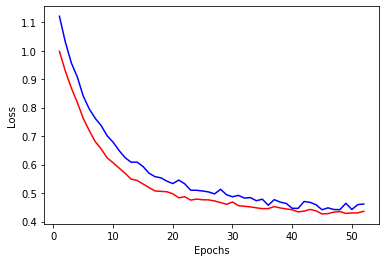

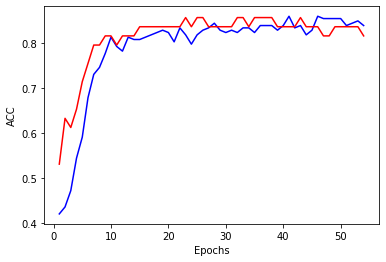

61/61 [==============================] - 0s 130us/sample - loss: 0.3584 - acc: 0.9016


*************  TEST RESULT  ******************
    
Loss: 0.35838073931756564
Accuracy: 90.16393423080444

***********************************************


[0.35838073931756564, 0.90163934]

In [80]:
tf.get_logger().setLevel('WARNING')
tf.autograph.set_verbosity(2)

#FitModel(epochs, batch-size, neurons)
fitModel(54,4,13)
plot()
evaluate()


## RESULTS:

## 1:    
    
    ***********************************************************************************
    Layers: 
 
    Dense1 - neurons: 68, activation: relu, regularizer: L2(0.1)

    Dropout - 0.4

    Dense2 - neurons: 68, activation: relu, regularizer: L2(0.1)

    Dropout - 0.4

    Dense(output) - neurons: 1)
    
    Optimizer:adam
    
    Batch-size: 10
    epochs: 250
    ***********************************************************************************  
    
    Result:
    
    Loss: 0.42949211988292757
    Accuracy: 91.80327653884888


## 2:    
    ***********************************************************************************
    Layers: 
 
    Dense1 - neurons: 68, activation: relu, regularizer: L2(0.1)

    Dropout - 0.4

    Dense2 - neurons: 68, activation: relu, regularizer: L2(0.1)

    Dropout - 0.4

    Dense(output) - neurons: 1)
    
    Optimizer:adam
    
    Batch-size:4
    epochs: 250
    ***********************************************************************************
    
    Result:

    Loss: 0.3861997435327436
    Accuracy: 91.80327653884888

## 3:
    
    ***********************************************************************************
    Layers: 
 
    Dense1 - neurons: 84, activation: relu, regularizer: L2(0.05)

    Dropout - 0.4

    Dense2 - neurons: 84, activation: relu, regularizer: L2(0.1)

    Dropout - 0.4

    Dense(output) - neurons: 1)
    
    Optimizer: adam
    
    Batch-size: 4
    epochs: 115
    ***********************************************************************************
    
    
    TEST RESULT:
    
    Loss: 0.40598516874626034
    Accuracy: 86.8852436542511

    ***********************************************
    

## 4:
    
    ***********************************************************************************
    Layers: 
 
    Dense1 - neurons: 84, activation: relu, regularizer: L2(0.05)

    Dropout - 0.4

    Dense2 - neurons: 84, activation: relu, regularizer: L2(0.1)

    Dropout - 0.4

    Dense(output) - neurons: 1)
    
    Optimizer: adam
    
    Batch-size: 4
    epochs: 65
    ***********************************************************************************
    
    *************  TEST RESULT  ******************
    
    Loss: 0.406089111429746
    Accuracy: 90.16393423080444

    ***********************************************

## 5:

    ***********************************************************************************
    Layers: 
 
    Dense1 - neurons: 84, activation: relu, regularizer: L2(0.05)

    Dropout - 0.4

    Dense2 - neurons: 84, activation: relu, regularizer: L2(0.1)

    Dropout - 0.4

    Dense(output) - neurons: 1)
    
    Optimizer: adam
    
    Batch-size: 4
    epochs: 10
    ***********************************************************************************
    
    *************  TEST RESULT  ******************
    
    Loss: 0.5175350904464722
    Accuracy: 90.16393423080444

    ***********************************************

## 6:

    ***********************************************************************************
    Layers: 
 
    Dense1 - neurons: 16, activation: relu, regularizer: L2(0.05)

    Dropout - 0.4

    Dense2 - neurons: 16, activation: relu, regularizer: L2(0.1)

    Dropout - 0.4

    Dense(output) - neurons: 1)
    
    Optimizer: adam
    
    Batch-size: 4
    epochs: 150
    ***********************************************************************************
    
    *************  TEST RESULT  ******************
    
    Loss: 0.39709243178367615
    Accuracy: 90.16393423080444

    ***********************************************

## 7:

    ***********************************************************************************
    Layers: 
 
    Dense1 - neurons: 16, activation: relu, regularizer: L2(0.05)

    Dropout - 0.2

    Dense2 - neurons: 16, activation: relu, regularizer: L2(0.1)

    Dropout - 0.2

    Dense(output) - neurons: 1)
    
    Optimizer: adam
    
    Batch-size: 4
    epochs: 200
    ***********************************************************************************
    
    *************  TEST RESULT  ******************
    
    Loss: 0.3838785530113783
    Accuracy: 90.16393423080444
    
    ***********************************************

## 8:
    ***********************************************************************************
    Layers: 
 
    Dense1 - neurons: 16, activation: relu, regularizer: L2(0.05)

    Dropout - 0.4

    Dense2 - neurons: 8, activation: relu, regularizer: L2(0.1)

    Dropout - 0.4

    Dense(output) - neurons: 1, activation: sigmoint)
    
    Optimizer: adam
    
    Batch-size: 4
    epochs: 500
    ***********************************************************************************
    
    *************  TEST RESULT  ******************

    Loss: 0.39709243178367615
    Accuracy: 90.16393423080444

    ***********************************************

## 9:

    ***********************************************************************************
    Layers: 
 
    Dense1 - neurons: 13, activation: relu, regularizer: L2(0.005)

    Dropout - 0.2

    Dense2 - neurons: 5, activation: relu, regularizer: L2(0.005)

    Dropout - 0.2
    
    Dense2 - neurons: 5, activation: relu, regularizer: L2(0.005)

    Dropout - 0.2


    Dense(output) - neurons: 1)
    
    Optimizer: adam
    
    Batch-size: 4
    epochs: 100
    ***********************************************************************************
    
    *************  TEST RESULT  ******************
    
    Loss: 0.3525885934712457
    Accuracy: 85.24590134620667

    ***********************************************

## 10

    ***********************************************************************************
    Layers: 
 
    Dense1 - neurons: 13, activation: relu, regularizer: L2(0.005)

    Dropout - 0.2

    Dense2 - neurons: 13, activation: relu, regularizer: L2(0.05)

    Dropout - 0.2

    Dense(output) - neurons: 1)
    
    Optimizer: adam
    
    Batch-size: 4
    epochs: 150
    ***********************************************************************************
    
    *************  TEST RESULT  ******************
    
    Loss: 0.3697339247484676
    Accuracy: 88.52459192276001

    ***********************************************

## 11

    ***********************************************************************************
    Layers: 
 
    Dense1 - neurons: 13, activation: relu, regularizer: L2(0.005)

    Dropout - 0.1

    Dense2 - neurons: 9, activation: relu, regularizer: L2(0.005)

    Dropout - 0.1

    Dense(output) - neurons: 1, activation: sigmoid)
    
    Optimizer: adam
    
    Batch-size: 2
    epochs: 50
    ***********************************************************************************
    
    *************  TEST RESULT  ******************
    
    Loss: 0.35020713337132187
    Accuracy: 90.16393423080444

    ***********************************************